In [ ]:
!pip install mlflow
!pip install gdown

##Dataset
!gdown 10xqEKqtA04JSKU2rF0XZQP9X34ovtgoY

    

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████████████████████████████████| 4.34G/4.34G [01:09<00:00, 62.5MB/s]


In [ ]:
## We save data on GG drive, it has many problems, this for force to download
!pip install --upgrade --no-cache-dir gdown
!python -m gdown.cli "https://drive.google.com/uc?id=10xqEKqtA04JSKU2rF0XZQP9X34ovtgoY&confirm=t"

  File "<command-2384972173426165>", line 1
    L!pip install --upgrade --no-cache-dir gdown
     ^
SyntaxError: invalid syntax


In [ ]:
#%cd /databricks/driver
#!gdown 1ZrayeVD2iZgfgB3sIt-L9LEn4zNFGgiu
# !python -m gdown.cli "https://drive.google.com/uc?id=1ZrayeVD2iZgfgB3sIt-L9LEn4zNFGgiu&confirm=t"

/databricks/driver
Downloading...
From: https://drive.google.com/uc?id=1ZrayeVD2iZgfgB3sIt-L9LEn4zNFGgiu
To: /databricks/driver/yelp_academic_dataset_review.json
 42%|████████████████                      | 2.2

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████████████████████████████████| 5.34G/5.34G [01:41<00:00, 52.7MB/s]


In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import Row
import numpy as np
from datetime import datetime
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import Window
from pyspark.sql.window import *
import math

In [ ]:
%cd /databricks/driver
!mkdir yelp_dataset
%cd /databricks/driver/yelp_dataset
# load file
my_tar = tarfile.open('/databricks/driver/yelp_dataset.tar')
#my_tar.extract('yelp_academic_dataset_review.json',".")
my_tar.extractall(".")
my_tar.close()

#!rm /databricks/driver/yelp_dataset.tar

/databricks/driver
/databricks/driver/yelp_dataset


In [ ]:
%cd /databricks/driver/yelp_dataset
!ls

/databricks/driver/yelp_dataset
Dataset_User_Agreement.pdf	     yelp_academic_dataset_review.json
yelp_academic_dataset_business.json  yelp_academic_dataset_tip.json
yelp_academic_dataset_checkin.json   yelp_academic_dataset_user.json


In [ ]:
# Load pyspark sesion
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '5000')\
        .getOrCreate()

In [ ]:
# This is read json data

df = spark.read.json("file:///databricks/driver/yelp_dataset/yelp_academic_dataset_review.json")
# df = spark.read.json("file:///databricks/driver/yelp_academic_dataset_review.json")
df.printSchema()
df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [ ]:
ratings=df.select("*")

In [ ]:
# This cmd to convert userid string to int

userRatings=ratings.groupBy("user_id").count()
## take id type int
window = Window.orderBy(col('user_id'))
userRatings = userRatings.withColumn('userid', row_number().over(window))

##Because ALS in spark require users or items is  in int type, we must process it

## if you use this, for the large data, it processes wrong
# userRatings=ratings.groupBy("user_id").count().withColumn("userid", monotonically_increasing_id().cast(IntegerType()))
userRatings.show(5)

+--------------------+-----+------+
|             user_id|count|userid|
+--------------------+-----+------+
|---1lKK3aKOuomHnw...|    1|     1|
|---2PmXbF47D870st...|   28|     2|
|---UgP94gokyCDuB5...|   11|     3|
|---fa6ZK37T9NjkGK...|    1|     4|
|---r61b7EpVPkb4UV...|    5|     5|
+--------------------+-----+------+
only showing top 5 rows



In [ ]:
## as same as business_id, then join 2 table to source table, we have the new table

buiRatings=ratings.groupBy("business_id").count()
## take id type int
window = Window.orderBy(col('business_id'))
buiRatings = buiRatings.withColumn('businessid', row_number().over(window))

# buiRatings=ratings.groupBy("business_id").count().withColumn("businessid", monotonically_increasing_id().cast(IntegerType()))
newratings=ratings.join(userRatings, ['user_id'])
newratings=newratings.join(buiRatings, ['business_id'])
newratings=newratings.select("userid","businessid","stars","date")

In [ ]:
print(f"num user: {userRatings.count()}")
print(f"num buisiness: {buiRatings.count()}")
newratings.show(5)
print(f"dataframe: {newratings}")

num user: 1987929
num buisiness: 150346
+------+----------+-----+-------------------+
|userid|businessid|stars|               date|
+------+----------+-----+-------------------+
|    20|     40541|  1.0|2015-05-03 03:53:01|
|    20|     76452|  5.0|2015-05-21 03:18:49|
|    36|    105552|  5.0|2019-04-18 05:17:58|
|    36|     29020|  2.0|2017-02-03 06:14:50|
|    36|    107435|  5.0|2019-04-18 05:15:48|
+------+----------+-----+-------------------+
only showing top 5 rows

dataframe: DataFrame[userid: int, businessid: int, stars: double, date: string]


In [ ]:
newratings=newratings.withColumn("stars",col("stars").cast(IntegerType()))
newratings=newratings.withColumn("date",to_timestamp("date"))

print(newratings)
newratings.show(5)

DataFrame[userid: int, businessid: int, stars: int, date: timestamp]
+------+----------+-----+-------------------+
|userid|businessid|stars|               date|
+------+----------+-----+-------------------+
|    20|     40541|    1|2015-05-03 03:53:01|
|    20|     76452|    5|2015-05-21 03:18:49|
|    36|    105552|    5|2019-04-18 05:17:58|
|    36|     29020|    2|2017-02-03 06:14:50|
|    36|    107435|    5|2019-04-18 05:15:48|
+------+----------+-----+-------------------+
only showing top 5 rows



In [ ]:
df1 = newratings.withColumn('year',year(newratings.date))
display(df1)

userid,businessid,stars,date,year
20,40541,1,2015-05-03T03:53:01.000+0000,2015
20,76452,5,2015-05-21T03:18:49.000+0000,2015
36,105552,5,2019-04-18T05:17:58.000+0000,2019
36,29020,2,2017-02-03T06:14:50.000+0000,2017
36,107435,5,2019-04-18T05:15:48.000+0000,2019
44,37583,4,2015-06-08T21:42:33.000+0000,2015
44,142071,4,2016-10-28T19:43:44.000+0000,2016
44,52545,5,2015-06-08T21:29:28.000+0000,2015
44,58717,5,2019-01-23T18:49:30.000+0000,2019
44,91273,1,2015-07-30T17:39:19.000+0000,2015


Databricks visualization. Run in Databricks to view.

# CHOOSE PARAM

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType
import numpy as np

schema = StructType([
  StructField('rank', IntegerType(), False),
  StructField('iter', IntegerType(), False),
  StructField('reg', FloatType(), False),
  StructField('rmse', FloatType(), False)
  ])
emptyRDD = spark.sparkContext.emptyRDD()

param = spark.createDataFrame(emptyRDD,schema)



def tuning(rank,iter,reg):
  als= ALS(rank=rank, maxIter=iter, regParam=reg, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(training) 
  predictions=model.transform(validating)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)  
  print(f"rank: {rank},iter: {iter},reg: {reg} : RMSE={rmse}")

  added_row = [[rank,iter,reg,rmse]]
  newRow = spark.createDataFrame(added_row, schema)
  end=datetime.now()
  return newRow

ran=[0.3, 0.5]

for reg in ran:
    for rank in range(3, 17, 2):
        for iter in range(3, 17, 2):
            newRow=tuning(rank,iter,reg)
            param = param.union(newRow)

rank: 11,iter: 5,reg: 0.3 : RMSE=1.5730730119784089
rank: 11,iter: 6,reg: 0.3 : RMSE=1.5697754219136555
rank: 11,iter: 7,reg: 0.3 : RMSE=1.5677536746472456
rank: 13,iter: 5,reg: 0.3 : RMSE=1.5729158984520226
rank: 13,iter: 6,reg: 0.3 : RMSE=1.569594275242874
rank: 13,iter: 7,reg: 0.3 : RMSE=1.5675570125885538
rank: 15,iter: 5,reg: 0.3 : RMSE=1.5729738921303908
rank: 15,iter: 6,reg: 0.3 : RMSE=1.5694638290199452
rank: 15,iter: 7,reg: 0.3 : RMSE=1.567299996193823
rank: 11,iter: 5,reg: 0.5 : RMSE=1.6086139650508753


In [ ]:
## all value I just write to this, run this to see
!rm score.txt
!gdown 1ZI_7JeAB5ChCdF0eWKhs22O48Q3bLJwy
# !gdown 1h50XzxQsxYioeaRxHdSkYTVPSqAGiDhx

rm: cannot remove 'score.txt': No such file or directory
Downloading...
From: https://drive.google.com/uc?id=1ZI_7JeAB5ChCdF0eWKhs22O48Q3bLJwy
To: /databricks/driver/yelp_dataset/score.txt
100%|██████████████████████████████████████| 3.12k/3.12k [00:00<00:00, 3.90MB/s]


In [ ]:
# path="file:///databricks/driver/yelp_dataset/t.txt"
path="file:///databricks/driver/score.txt"
output= spark.read.options(header=True).csv(path)

output=output.withColumn("ranks",col("ranks").cast(IntegerType()))
output=output.withColumn("iter",col("iter").cast(IntegerType()))
output=output.withColumn("reg", col("reg").cast(DoubleType()))
output=output.withColumn("rmse",col("rmse").cast(DoubleType()))


In [ ]:
display(output)

ranks,iter,reg,rmse
3,3,0.3,1.4523422578126342
3,4,0.3,1.4514993313997395
3,5,0.3,1.454205271833971
3,6,0.3,1.4566858357453232
3,7,0.3,1.458570797956474
3,8,0.3,1.460010278654836
3,9,0.3,1.4611262494153512
3,10,0.3,1.4620119022135958
3,11,0.3,1.462731065589978
3,12,0.3,1.4633282935418674


Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

## So, the  best is rank=4, iter=4, reg=0.35

## We always divide train/val/test: 7/2/1

# RUN NORMAL

### Split Data

In [ ]:
num=int(newratings.count()*0.1)
ortherDate=newratings.orderBy(col("date").desc())
testing=ortherDate.limit(int(num))
train=ortherDate.subtract(testing)
 
validate=train.limit(int(num)*2)
training=train.subtract(validate)
 
print(f"training: {training.count()}")
print(f"validate: {validate.count()}")
print(f"testing: {testing.count()}")

training: 4893172
validate: 1398056
testing: 699028


### Train

In [ ]:
def trainModel(train,test):
  start=datetime.now()
  als= ALS(rank=4, maxIter=4, regParam=0.35, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(train)
  ski=datetime.now()-start
  print(f"Time fit model: {ski}")
  predictions=model.transform(test)
  print(f"Time predict: {datetime.now()-ski}")
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print(f"RMSE={rmse}")
  end=datetime.now()
  print(f"processing time: {end-start}")
  return model

model=trainModel(training,validate)

Time fit model: 0:16:14.815730
Time predict: 2022-12-15 02:46:44.202398
RMSE=1.3775699181833807
processing time: 0:22:46.310865


# STRATIFIED SAMPLING

In [ ]:
display(newratings)

userid,businessid,stars,date
553,83661,4,2018-06-14T04:55:47.000+0000
1990,51643,5,2019-07-23T19:39:50.000+0000
2388,51643,4,2016-03-07T16:10:49.000+0000
2388,7902,3,2012-03-19T00:27:30.000+0000
2388,7902,2,2011-05-05T02:53:46.000+0000
2388,79602,1,2014-09-17T01:58:51.000+0000
2976,91566,5,2016-12-23T23:53:45.000+0000
5154,83937,4,2017-06-24T18:36:08.000+0000
5422,20677,5,2020-10-26T05:50:17.000+0000
6159,10787,4,2019-05-04T19:15:51.000+0000


Databricks visualization. Run in Databricks to view.

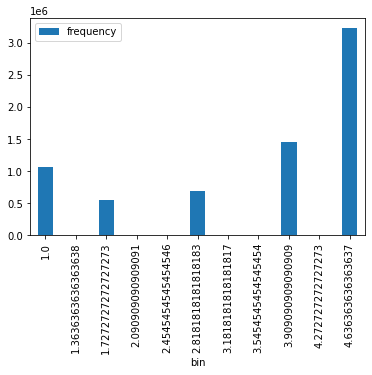

In [ ]:
gre_histogram = newratings.select('stars').rdd.flatMap(lambda x: x).histogram(11)

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

### Split Data

In [ ]:
rat1=train.where(col("stars")==1)
rat2=train.where(col("stars")==2)
rat3=train.where(col("stars")==3)
rat4=train.where(col("stars")==4)
rat5=train.where(col("stars")==5)

In [ ]:
def Split(data,num):
    ortherDate=data.orderBy(col("date").desc())
    testing=ortherDate.limit(int(num))
    training=ortherDate.subtract(testing)
    return training,testing
  
train1,val1=Split(rat1,math.ceil(rat1.count()*2/9))
train2,val2=Split(rat2,math.ceil(rat2.count()*2/9))
train3,val3=Split(rat3,math.ceil(rat3.count()*2/9))
train4,val4=Split(rat4,math.ceil(rat4.count()*2/9))
train5,val5=Split(rat5,math.ceil(rat5.count()*2/9))

In [ ]:
mertrain=train1.union(train2).union(train3).union(train4).union(train5)
merval=val1.union(val2).union(val3).union(val4).union(val5)
print(mertrain.count())
print(merval.count())

4893174
1398054


### Train

In [ ]:
model=trainModel(mertrain,merval)

Time fit model: 0:36:01.583510
Time predict: 2022-12-15 05:18:59.094459
RMSE=1.4628903414659034
processing time: 0:51:48.873999


In [ ]:
def Split(data,num):
    testing=data.limit(int(num))
    training=data.subtract(testing)
    return training,testing
  
train1,val1=Split(rat1,math.ceil(rat1.count()*2/9))
train2,val2=Split(rat2,math.ceil(rat2.count()*2/9))
train3,val3=Split(rat3,math.ceil(rat3.count()*2/9))
train4,val4=Split(rat4,math.ceil(rat4.count()*2/9))
train5,val5=Split(rat5,math.ceil(rat5.count()*2/9))
mertrain=train1.union(train2).union(train3).union(train4).union(train5)
merval=val1.union(val2).union(val3).union(val4).union(val5)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2081640221206470> in <module>
     11 mertrain=train1.union(train2).union(train3).union(train4).union(train5)
     12 merval=val1.union(val2).union(val3).union(val4).union(val5)
---> 13 model=trainModel(mertrain,merval)

NameError: name 'trainModel' is not defined

In [ ]:
model=trainModel(mertrain,merval)

Time fit model: 0:35:10.021739
Time predict: 2022-12-15 09:50:27.244527
RMSE=1.3848174823249808
processing time: 0:50:34.677839


# CONFUSE

In [ ]:
df2=newratings.groupBy('userid').agg(min(year(newratings.date)).alias('minYear'))
display(df2)

userid,minYear
172959,2019
240209,2019
315750,2013
459512,2011
493058,2014
573605,2012
615950,2011
682355,2018
728388,2019
1271374,2019


Databricks visualization. Run in Databricks to view.

In [ ]:
df3=newratings.groupBy('businessid').agg(min(year(newratings.date)).alias('minYear'))
display(df3)

businessid,minYear
2659,2013
1238,2017
137377,2015
24663,2019
73470,2013
99621,2008
46266,2019
15790,2010
142084,2013
74166,2012


Databricks visualization. Run in Databricks to view.

## Split Data

In [ ]:
"""
# newTrain = None
# userNew=new.groupBy('userid').count().select('userid')
# lstuserNew=userNew.rdd.flatMap(lambda x: x).collect()

# for i in lstuserNew:
#     userI=new.filter(col('userid')==i)
#     newTrain=SplitTest(newTrain,userI)
"""

def Confuse(train,test):
    userTrain=train.groupBy('userid').count().select('userid')
    duplicate=test.join(userTrain,['userid'])
    new=test.subtract(duplicate)
    """*"""
    newRowTrain,_=new.randomSplit([0.3,0.7]) 
    """*"""
    numNewTrain=newRowTrain.count()
    newRowTest=train.orderBy(col("date").desc()).limit(numNewTrain)
    newTrain=train.subtract(newRowTest)
    newTest=test.subtract(newRowTrain).union(newRowTest)
    return newRowTrain,newTrain,newTest
    
def SplitTest(source,data):
    train,test=data.randomSplit([0.3,0.7])
    try:
        return source.union(train)
    except:
        return train


In [ ]:
rowNewTrain1,newTrain,newVal=Confuse(training,validate)
rowNewTrain2,newTrain,newTest=Confuse(newTrain,testing)
newTrain=newTrain.union(rowNewTrain1).union(rowNewTrain2)

print(f"training: {newTrain.count()}")
print(f"validate: {newVal.count()}")
print(f"testing: {newTest.count()}")

training: 4893172
validate: 1476696
testing: 795873


## Train

In [ ]:
model=trainModel(newTrain,newVal)

Time fit model: 0:22:23.082103
Time predict: 2022-12-15 12:59:10.466455
RMSE=1.3570518205204398
processing time: 0:30:48.589873


In [ ]:
model=trainModel(newTrain,newVal)

Time fit model: 0:13:28.919948
Time predict: 2022-12-15 13:32:25.515418
RMSE=1.3570518205204398
processing time: 0:22:05.822452


In [ ]:
predictions=model.transform(newTest)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"test RMSE={rmse}")

validate RMSE=1.478153630413262


In [ ]:
print(f"test RMSE={rmse}")

test RMSE=1.478153630413262


# SAVE MODEL

In [ ]:
als= ALS(rank=4, maxIter=4, regParam=0.35, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
model = als.fit(training)
model.save('file:///databricks/driver/yelp_dataset/save1')
!ls

Dataset_User_Agreement.pdf	     yelp_academic_dataset_checkin.json
save				     yelp_academic_dataset_review.json
savemodel			     yelp_academic_dataset_tip.json
yelp_academic_dataset_business.json  yelp_academic_dataset_user.json


In [ ]:
import shutil
shutil.make_archive('save1', 'zip', 'save1')

Out[20]: '/databricks/driver/yelp_dataset/save.zip'

# LOAD MODEL

In [ ]:
!gdown 18e1h76domGD_WVnl4vF6OaUyUXVGxqeC
import shutil
shutil.unpack_archive('/databricks/driver/yelp_dataset/save1.zip',"save1")
!ls

/bin/bash: gdown: command not found


---------------------------------------------------------------------------
ReadError                                 Traceback (most recent call last)
<command-3998707776896433> in <cell line: 3>()
      1 get_ipython().system('gdown 18e1h76domGD_WVnl4vF6OaUyUXVGxqeC')
      2 import shutil
----> 3 shutil.unpack_archive('/databricks/driver/yelp_dataset/save1.zip',"save1")
      4 get_ipython().system('ls')

/usr/lib/python3.9/shutil.py in unpack_archive(filename, extract_dir, format)
   1254         func = _UNPACK_FORMATS[format][1]
   1255         kwargs = dict(_UNPACK_FORMATS[format][2])
-> 1256         func(filename, extract_dir, **kwargs)
   1257 
   1258 

/usr/lib/python3.9/shutil.py in _unpack_zipfile(filename, extract_dir)
   1149 
   1150     if not zipfile.is_zipfile(filename):
-> 1151         raise ReadError("%s is not a zip file" % filename)
   1152 
   1153     zip = zipfile.ZipFile(filename)

ReadError: /databricks/driver/yelp_dataset/save1.zip is not a zip file

In [ ]:
%cd /databricks/driver/yelp_dataset/save
!ls

/databricks/driver/yelp_dataset/save
itemFactors  metadata  userFactors


In [ ]:
model=ALSModel.load("file:////databricks/driver/yelp_dataset/save1")

Out[19]: 1.6338734174594913

# Recommend

In [ ]:
# just collect 3 restaurant and show for 2 users
# model.recommendForAllUsers(3).take(2)
# model.recommendForUserSubset
usersCol = newratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(usersCol, 10)
userSubsetRecs.show(10)

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Out[78]: [Row(userid=26, recommendations=[Row(businessid=26360, rating=14.034025192260742), Row(businessid=81714, rating=14.020951271057129), Row(businessid=86874, rating=13.82781982421875)]),
 Row(userid=28, recommendations=[Row(businessid=21273, rating=4.047173976898193), Row(businessid=28724, rating=3.9795403480529785), Row(businessid=121769, rating=3.973750591278076)])]

In [ ]:
predictCross.show(10)

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictCross)
print(f"RMSE={rmse}")
print(f"end Time: {datetime.now()}")